## DSGD 알고리듬 구현

In [2]:
using Pkg
Pkg.add("IJulia")

   Resolving package versions...


  No Changes to `~/.julia/environments/v1.9/Project.toml`
  No Changes to `~/.julia/environments/v1.9/Manifest.toml`


In [3]:
versioninfo()

Julia Version 1.9.3
Commit bed2cd540a1 (2023-08-24 14:43 UTC)
Build Info:
  Official https://julialang.org/ release
Platform Info:
  OS: macOS (x86_64-apple-darwin22.4.0)
  CPU: 4 × Intel(R) Core(TM) i5-6500 CPU @ 3.20GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-14.0.6 (ORCJIT, skylake)
  Threads: 1 on 4 virtual cores
Environment:
  JULIA_NUM_THREADS = 


In [4]:
Pkg.status()

Status `~/.julia/environments/v1.9/Project.toml`
  [6e4b80f9] BenchmarkTools v1.4.0
  [31c24e10] Distributions v0.25.104
  [7073ff75] IJulia v1.24.2
  [033835bb] JLD2 v0.4.38
  [2913bbd2] StatsBase v0.34.2


In [5]:
function find_best_c_and_beta_hat(c_values, eta, lambda, X, y, i, beta_hat)
    best_c = c_values[1]
    best_beta_hat = beta_hat
    min_error = Inf

    X_i = view(X, i, :)

    xi_yi_dot_product = dot(X_i, beta_hat)
    common_term = eta * X_i * (y[i] - xi_yi_dot_product)

    for c in c_values
        b_hat_temp = beta_hat + common_term

        beta_hat_temp = sign.(b_hat_temp) .* max.(abs.(b_hat_temp) .- c * eta * lambda, 0)

        dotproduct = dot(X_i, beta_hat_temp)
        residual = y[i] - dot(X_i, beta_hat_temp)
        error = (residual)^2

        if error < min_error
            min_error = error
            best_c = c
            best_beta_hat = beta_hat_temp
        end
    end

    return best_c, best_beta_hat
end


find_best_c_and_beta_hat (generic function with 1 method)

In [77]:
function DSGD_opt_onlyfinal(eta, X, y, k, α)
    c_values = [0.3, 0.35, 0.4, 0.45]
    p = size(X,2) # 데이터 차원
    n = size(X,1)  # 데이터 포인트의 수
    η = [eta / (i^0.51) for i in 1:n] #learning rate
    λ = [sqrt(log(p) / i) for i in 1:n] # penalty parameter

    # Initialization
    beta_hat = zeros(p) 
    beta_tilde = zeros(p)
    b_hat = zeros(p)
    gamma_hat = zeros(p-1)
    gamma_tilde = zeros(p-1)
    r_hat = zeros(p-1)
    beta_tilde_k_de = 0.0
    m_1k = 0.0
    m_2k = 0.0
    m_3k = zeros(p, 1)
    sigma_tilde_sum = 0.0
    tau_tilde_k_sum = 0.0

    sigma_tilde = 0.0
    tau_tilde_k = 0.0

    #sigma_tilde_vals = zeros(n)
    #tau_tilde_k_vals = zeros(n)


    z_alpha_2 = quantile(Normal(), 1 - α / 2)

    # 최종 결과 저장을 위한 변수
    final_beta_tilde_k_de = 0.0
    final_CI_left = 0.0
    final_CI_right = 0.0
    final_tau_tilde_k = 0.0

    # 주 계산 로직
    for i = 1:n

        X_i = view(X, i, :)  # X의 i번째 행에 대한 뷰 생성
        dot_product = dot(X_i, beta_hat)  # 내적 계산 결과 저장
        residual = y[i] - dot_product  # 잔차 계산
    
        # b_hat 업데이트
        b_hat .= beta_hat .+ η[i] .* X_i .* residual
        best_c, beta_hat = find_best_c_and_beta_hat(c_values, η[i], λ[i], X, y, i, beta_hat)
        beta_tilde = ((i - 1) * beta_tilde + beta_hat) / i


        X_i_k = view(X, i, [1:k-1; k+1:size(X,2)])  # X[i, -k] 생성 (p-1 차원)
        dot_product2 = dot(X_i_k, gamma_hat)  # 내적 계산 결과 저장
        residual2 = X[i,k] - dot_product2

        r_hat .= gamma_hat .+ η[i] .* X_i_k .* residual2



        for j in 1:length(gamma_hat)
            temp = r_hat[j] - best_c * η[i] * λ[i]
            gamma_hat[j] = sign(temp) * max(abs(temp), 0)
        end    


        # gamma_tilde의 효율적 평균 계산
        if i == 1
            gamma_tilde .= gamma_hat
        else
            gamma_tilde .= gamma_tilde .* (i - 1) ./ i .+ gamma_hat ./ i
        end

        
        dot_product3 = dot( X_i_k , gamma_tilde)
        z_ik = X[i,k] - dot_product3  
        m_1k += z_ik * X[i,k]
        m_2k += z_ik * y[i]        
        m_3k .+= z_ik .* vec(X_i')
        

        #sigma_tilde 계산 : online형식
        dot_product4 = dot(X_i, beta_tilde)
        residual4 = y[i] - dot_product4
        sigma_tilde_sum += (residual4)^2       
        sigma_tilde = sqrt(sigma_tilde_sum / i)


        #tau_tilde 계산 : online형식
        tau_tilde_k_sum += z_ik^2
        tau_tilde_k = sqrt(tau_tilde_k_sum ) / m_1k
        
        # beta_tilde_k_de 값 갱신
        beta_tilde_k_de = beta_tilde[k] + (m_2k - dot(m_3k, beta_tilde)) / m_1k

        # CI 계산
        #CI = (beta_tilde_k_de - z_alpha_2 * sigma_tilde * tau_tilde_k, beta_tilde_k_de + z_alpha_2 * sigma_tilde * tau_tilde_k)
        CI_left = beta_tilde_k_de - z_alpha_2 * sigma_tilde * tau_tilde_k
        CI_right = beta_tilde_k_de + z_alpha_2 * sigma_tilde * tau_tilde_k

        # 마지막 반복에서만 CI 값을 저장
        if i == n
            final_beta_tilde_k_de = beta_tilde_k_de
            final_CI_left = CI_left
            final_CI_right = CI_right
            final_tau_tilde_k = tau_tilde_k
        end
    end

    # 최종적으로 필요한 값만 반환
    return final_beta_tilde_k_de, final_tau_tilde_k ,final_CI_left, final_CI_right
end


DSGD_opt_onlyfinal (generic function with 1 method)

In [78]:
function DSGD_opt_for_plot(eta, X, y, k, α)
    c_values = [0.3, 0.35, 0.4, 0.45]
    p = size(X,2) # 데이터 차원
    n = size(X,1)  # 데이터 포인트의 수
    η = [eta / (i^0.51) for i in 1:n] #learning rate
    λ = [sqrt(log(p) / i) for i in 1:n] # penalty parameter

    # Initialization
    beta_hat = zeros(p) 
    beta_tilde = zeros(p)
    b_hat = zeros(p)
    gamma_hat = zeros(p-1)
    gamma_tilde = zeros(p-1)
    r_hat = zeros(p-1)
    beta_tilde_k_de = 0.0
    m_1k = 0.0
    m_2k = 0.0
    m_3k = zeros(p, 1)
    sigma_tilde_sum = 0.0
    tau_tilde_k_sum = 0.0

    sigma_tilde = 0.0
    tau_tilde_k = 0.0

    #sigma_tilde_vals = zeros(n)
    #tau_tilde_k_vals = zeros(n)


    z_alpha_2 = quantile(Normal(), 1 - α / 2)

    # 저장할 지점들을 배열로 정의
    save_points = [50, 100, 150, 200, 250, 300, 350, n]
    num_save_points = length(save_points)

    # 저장할 값들을 저장할 배열 생성
    saved_beta_tilde = Array{Float64, 1}(undef, num_save_points)
    saved_tau_tilde = Array{Float64, 1}(undef, num_save_points)
    saved_CI_left = Array{Float64, 1}(undef, num_save_points)
    saved_CI_right = Array{Float64, 1}(undef, num_save_points)

    save_index = 1

    # 주 계산 로직
    for i = 1:n

        X_i = view(X, i, :)  # X의 i번째 행에 대한 뷰 생성
        dot_product = dot(X_i, beta_hat)  # 내적 계산 결과 저장
        residual = y[i] - dot_product  # 잔차 계산
    
        # b_hat 업데이트
        b_hat .= beta_hat .+ η[i] .* X_i .* residual
        best_c, beta_hat = find_best_c_and_beta_hat(c_values, η[i], λ[i], X, y, i, beta_hat)
        beta_tilde = ((i - 1) * beta_tilde + beta_hat) / i


        X_i_k = view(X, i, [1:k-1; k+1:size(X,2)])  # X[i, -k] 생성 (p-1 차원)
        dot_product2 = dot(X_i_k, gamma_hat)  # 내적 계산 결과 저장
        residual2 = X[i,k] - dot_product2

        r_hat .= gamma_hat .+ η[i] .* X_i_k .* residual2



        for j in 1:length(gamma_hat)
            temp = r_hat[j] - best_c * η[i] * λ[i]
            gamma_hat[j] = sign(temp) * max(abs(temp), 0)
        end    


        # gamma_tilde의 효율적 평균 계산
        if i == 1
            gamma_tilde .= gamma_hat
        else
            gamma_tilde .= gamma_tilde .* (i - 1) ./ i .+ gamma_hat ./ i
        end

        
        dot_product3 = dot( X_i_k , gamma_tilde)
        z_ik = X[i,k] - dot_product3  
        m_1k += z_ik * X[i,k]
        m_2k += z_ik * y[i]        
        m_3k .+= z_ik .* vec(X_i')
        

        #sigma_tilde 계산 : online형식
        dot_product4 = dot(X_i, beta_tilde)
        residual4 = y[i] - dot_product4
        sigma_tilde_sum += (residual4)^2       
        sigma_tilde = sqrt(sigma_tilde_sum / i)


        #tau_tilde 계산 : online형식
        tau_tilde_k_sum += z_ik^2
        tau_tilde_k = sqrt(tau_tilde_k_sum ) / m_1k
        
        # beta_tilde_k_de 값 갱신
        beta_tilde_k_de = beta_tilde[k] + (m_2k - dot(m_3k, beta_tilde)) / m_1k

        # CI 계산
        #CI = (beta_tilde_k_de - z_alpha_2 * sigma_tilde * tau_tilde_k, beta_tilde_k_de + z_alpha_2 * sigma_tilde * tau_tilde_k)
        CI_left = beta_tilde_k_de - z_alpha_2 * sigma_tilde * tau_tilde_k
        CI_right = beta_tilde_k_de + z_alpha_2 * sigma_tilde * tau_tilde_k

        if i == save_points[save_index]
            saved_beta_tilde[save_index] = beta_tilde_k_de
            saved_tau_tilde[save_index] = tau_tilde_k
            saved_CI_left[save_index] = CI_left
            saved_CI_right[save_index] = CI_right
            save_index += 1
        end
    end

    # 최종적으로 필요한 값만 반환
    return saved_beta_tilde, saved_tau_tilde, saved_CI_left, saved_CI_right
end


DSGD_opt_for_plot (generic function with 1 method)

In [64]:
test22 = DSGD_calc_v3(0.0025, X_ind, y_ind, 0.05)

([1.0198694772471681, 0.9190125552405851, 1.1228861747943504, 0.09369499966366555, 0.08726135401404528, -0.006518014286375843, -0.14748971959451238, -0.18098878515359473, 0.02599525040383428, 0.16901270698672927  …  0.17596868466088347, 0.004213649631238533, 0.16937614378657875, 0.01534503628402887, -0.013217651806607198, -0.2564699251216805, 0.08816146072847453, -0.13626714009327978, -0.11572118691470547, 0.049932478270844925], [0.01020569294836488, 0.01014393949029201, 0.01039626398579897, 0.010195645088220778, 0.010161663078582057, 0.010353707700768568, 0.010317702446481655, 0.01019300658195781, 0.01029362276255544, 0.010208205821462616  …  0.010387469194298496, 0.010250600683050467, 0.010203603957484028, 0.010203905163710216, 0.010174154342777356, 0.010179186878395603, 0.010132462030606106, 0.010202813270100032, 0.01021126593519866, 0.010149932083367454], [0.9815634619835755 1.058175492510761;;; 0.8809383252089691 0.9570867852722011;;; 1.083864870808504 1.1619074787801968;;; … ;;; 

In [65]:
test22 = DSGD_calc_for_plot(0.0025, X_ind, y_ind, 0.05)

400-element Vector{Float64}:
  1.0198694772471681
  0.9190125552405851
  1.1228861747943504
  0.09369499966366555
  0.08726135401404528
 -0.006518014286375843
 -0.14748971959451238
 -0.18098878515359473
  0.02599525040383428
  0.16901270698672927
  ⋮
  0.004213649631238533
  0.16937614378657875
  0.01534503628402887
 -0.013217651806607198
 -0.2564699251216805
  0.08816146072847453
 -0.13626714009327978
 -0.11572118691470547
  0.049932478270844925

In [49]:
testX = DSGD_opt_for_plot(0.0025, X_ind, y_ind, 1,0.05)

([1.098498873681281, 1.0198694772471681, 2.2865507574e-314, 2.2853725334e-314, 2.2576783753e-314, 2.2576783753e-314, 2.2865508206e-314, 2.285372581e-314], [0.01924980202161841, 0.01020569294836488, 2.4854222114e-314, 2.4854222114e-314, 2.285372304e-314, 2.285372304e-314, 2.2853727863e-314, 2.4854222114e-314], [1.0251726222054605, 0.9815634619835755, 2.448251131e-314, 2.448251131e-314, 2.448251131e-314, 2.448251131e-314, 2.448251131e-314, 2.448251131e-314], [1.1718251251571017, 1.058175492510761, 5.0e-324, 0.0, 0.0, 5.0e-324, 5.0e-324, 5.0e-324])

In [53]:
testX[4]

8-element Vector{Float64}:
 1.1718251251571017
 1.058175492510761
 5.0e-324
 0.0
 0.0
 5.0e-324
 5.0e-324
 5.0e-324

In [56]:
length(testX[1])

8

In [79]:
function DSGD_calc_onlyfinal(eta, X, y, α)
    p = size(X,2)
    beta_tilde_de = zeros(p)
    tau_tilde_array = zeros(p)
    final_CI_left_array = zeros(p)
    final_CI_right_array = zeros(p)
    
    
    for i in 1:p
        result = DSGD_opt_onlyfinal(eta, X, y, i, α)
        beta_tilde_de[i] = result[1]
        tau_tilde_array[i] = result[2]
        final_CI_left_array[i] = result[3]
        final_CI_right_array[i] = result[4]
    end

    return beta_tilde_de, tau_tilde_array, final_CI_left_array, final_CI_right_array
end
        

DSGD_calc_onlyfinal (generic function with 1 method)

In [80]:
function DSGD_calc_for_plot(eta, X, y, α)
    p = size(X,2)
    l = length(DSGD_opt_for_plot(eta, X, y, 1, α)[1])
    beta_tilde_de = zeros(l,p)
    tau_tilde_array = zeros(l,p)
    final_CI_left_array = zeros(l,p)
    final_CI_right_array = zeros(l,p)
    
    for i in 1:p
        result = DSGD_opt_for_plot(eta, X, y, i, α)
        beta_tilde_de[:,i] = result[1]
        tau_tilde_array[:,i] = result[2]
        final_CI_left_array[:,i] = result[3]
        final_CI_right_array[:,i] = result[4]
    end

    return beta_tilde_de, tau_tilde_array, final_CI_left_array, final_CI_right_array
end
        

DSGD_calc_for_plot (generic function with 1 method)

## 실험

In [11]:
Pkg.add("StatsBase")

   Resolving package versions...


  No Changes to `~/.julia/environments/v1.9/Project.toml`
  No Changes to `~/.julia/environments/v1.9/Manifest.toml`


In [12]:
Pkg.add("Distributions")

   Resolving package versions...


  No Changes to `~/.julia/environments/v1.9/Project.toml`
  No Changes to `~/.julia/environments/v1.9/Manifest.toml`


In [13]:
using Random, StatsBase, Statistics, Distributions

In [14]:
using LinearAlgebra

In [15]:
function dep_sampling(seed, n, p, s0)
    Random.seed!(seed)
    ρ = 0.5
    Σ = [ρ^abs(i - j) for i in 1:p, j in 1:p]
    μ = zeros(Float64, p)
    X = rand(MvNormal(μ, Σ), n)'
    X[:,:] = standardize(ZScoreTransform, X, dims = 1)
    
    β = [ones(s0)*1; ones(s0)*0.1; zeros(p - 2*s0)]
    eps = randn(n)
    eps .-= mean(eps)
    y = X * β + eps
    return X, y, β
end 

dep_sampling (generic function with 1 method)

In [16]:
function indep_sampling(seed, n, p, s0)
    Random.seed!(seed)
    X = randn(n, p)
    X[:,:] = standardize(ZScoreTransform, X, dims = 1)
    β = [ones(s0)*1; ones(s0)*0.1; zeros(p - 2*s0)]
    eps = randn(n)
    eps .-= mean(eps)
    y = X * β + eps
    return X, y, β
end 

indep_sampling (generic function with 1 method)

In [17]:
Pkg.add("BenchmarkTools")

   Resolving package versions...


  No Changes to `~/.julia/environments/v1.9/Project.toml`
  No Changes to `~/.julia/environments/v1.9/Manifest.toml`


In [18]:
using BenchmarkTools

In [19]:
Pkg.add("JLD2")

   Resolving package versions...


  No Changes to `~/.julia/environments/v1.9/Project.toml`
  No Changes to `~/.julia/environments/v1.9/Manifest.toml`


In [20]:
using JLD2

In [75]:
X_ind, y_ind, β_ind = indep_sampling(77, 400, 2000, 3)

([0.5584634261753936 -0.08113808202902698 … 0.9705655754272062 1.217092855913592; 0.6597360155573786 1.475447279644004 … 1.7153523933646446 0.08099148834756725; … ; 0.3080326149351107 0.9701694146131304 … -0.02389963885791062 -2.4719967298419214; -0.9045298471522799 -0.8248480797151634 … 1.5170919415444837 0.6803492341355298], [2.4806638286460725, 1.702302571381562, 3.3314037069291915, -5.710266849046327, -2.0091802122468496, -1.9963607937277787, 0.7025693081035939, -0.26616268284082717, -0.7963537316044143, -0.1974676638014869  …  2.9152705265277663, -1.1730446019725926, -0.9751191940384891, -2.9974323058123744, -1.6708419909553751, 0.18559227730427663, 1.8743360630388932, 0.3072526945744146, 2.8618894692354586, -0.8549305502746569], [1.0, 1.0, 1.0, 0.1, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

In [69]:
@time n100_p400_ind = DSGD_calc_onlyfinal(0.0025, X_ind, y_ind, 0.05)

  1.227271 seconds (564.00 k allocations: 1.745 GiB, 34.96% gc time)


([1.0198694772471681, 0.9190125552405851, 1.1228861747943504, 0.09369499966366555, 0.08726135401404528, -0.006518014286375843, -0.14748971959451238, -0.18098878515359473, 0.02599525040383428, 0.16901270698672927  …  0.17596868466088347, 0.004213649631238533, 0.16937614378657875, 0.01534503628402887, -0.013217651806607198, -0.2564699251216805, 0.08816146072847453, -0.13626714009327978, -0.11572118691470547, 0.049932478270844925], [0.01020569294836488, 0.01014393949029201, 0.01039626398579897, 0.010195645088220778, 0.010161663078582057, 0.010353707700768568, 0.010317702446481655, 0.01019300658195781, 0.01029362276255544, 0.010208205821462616  …  0.010387469194298496, 0.010250600683050467, 0.010203603957484028, 0.010203905163710216, 0.010174154342777356, 0.010179186878395603, 0.010132462030606106, 0.010202813270100032, 0.01021126593519866, 0.010149932083367454], [0.9815634619835755, 0.8809383252089691, 1.083864870808504, 0.055426698006193834, 0.049120600322840456, -0.04537958764812994, -0

In [74]:
@time n400_p800_ind = DSGD_calc_for_plot(0.0025, X_ind, y_ind, 0.05)

 17.102362 seconds (4.81 M allocations: 27.331 GiB, 25.18% gc time, 2.49% compilation time)


([0.702546255470376 1.127390185519775 … 0.4227782284849733 0.232019469082197; 0.5505352498965193 1.1821494532300598 … 0.2621906234961639 0.29292015113805964; … ; 0.8573588919999341 0.8675452836807311 … 0.040370916202181514 0.04296247544393393; 0.8316524335548285 0.9075008832364172 … -0.014712478776861477 -0.001418548525901963], [0.017877015348879612 0.023843456809265307 … 0.020976668808710585 0.029373438932470644; 0.009473439199629756 0.01039490848117629 … 0.009836631585772993 0.012789108296810237; … ; 0.002943079800932987 0.0029714269658110966 … 0.0029744694573262584 0.0031174048569016393; 0.0026480853762944163 0.002646996163978087 … 0.0026373653686474043 0.0026823357812093], [0.6291958908346642 1.029559187615247 … 0.3367098174032592 0.11149865426751575; 0.5113468022004555 1.1391491954846078 … 0.22149977044043523 0.2400158899708553; … ; 0.846397184380371 0.85647799505275 … 0.029292295600662495 0.03135148189821746; 0.8218312255955169 0.8976837149431852 … -0.024493928416683387 -0.011366

In [75]:
n400_p800_ind[1]

8×800 Matrix{Float64}:
 0.702546  1.12739   0.823191  …  -0.313199    0.422778    0.232019
 0.550535  1.18215   1.08355      -0.0818129   0.262191    0.29292
 0.768671  1.10961   1.06795      -0.0398714   0.193484    0.154528
 0.833046  0.930674  0.993227     -0.0215905   0.157518    0.10674
 0.824896  0.907552  0.968928     -0.0853834   0.115933    0.0718621
 0.839187  0.861786  0.930078  …  -0.0180984   0.0786601   0.0613441
 0.857359  0.867545  0.87314      -0.0365847   0.0403709   0.0429625
 0.831652  0.907501  0.897386     -0.0778693  -0.0147125  -0.00141855

In [80]:
#n400_p400_ind[1][8,:]

#mean(n400_p800_ind[1][8,:] - β_ind)
mean(n400_p800_ind[1][8,7:800] - β_ind[7:800])

0.010139033788114779

In [70]:
mean(n100_p400_ind[1] - β_ind)

0.05573782519891783

In [67]:
test22

([1.0198694772471681, 0.9190125552405851, 1.1228861747943504, 0.09369499966366555, 0.08726135401404528, -0.006518014286375843, -0.14748971959451238, -0.18098878515359473, 0.02599525040383428, 0.16901270698672927  …  0.17596868466088347, 0.004213649631238533, 0.16937614378657875, 0.01534503628402887, -0.013217651806607198, -0.2564699251216805, 0.08816146072847453, -0.13626714009327978, -0.11572118691470547, 0.049932478270844925], [0.01020569294836488, 0.01014393949029201, 0.01039626398579897, 0.010195645088220778, 0.010161663078582057, 0.010353707700768568, 0.010317702446481655, 0.01019300658195781, 0.01029362276255544, 0.010208205821462616  …  0.010387469194298496, 0.010250600683050467, 0.010203603957484028, 0.010203905163710216, 0.010174154342777356, 0.010179186878395603, 0.010132462030606106, 0.010202813270100032, 0.01021126593519866, 0.010149932083367454], [0.9815634619835755 1.058175492510761;;; 0.8809383252089691 0.9570867852722011;;; 1.083864870808504 1.1619074787801968;;; … ;;; 

In [26]:
@benchmark DSGD_calc_onlyfinal(0.0025, X_ind, y_ind, 0.05)

BenchmarkTools.Trial: 4 samples with 1 evaluation.
 Range (min … max):  1.171 s …    1.876 s  ┊ GC (min … max): 32.91% … 37.29%
 Time  (median):     1.365 s               ┊ GC (median):    31.82%
 Time  (mean ± σ):   1.444 s ± 319.104 ms  ┊ GC (mean ± σ):  33.82% ±  2.64%

  █    █                    █                              █  
  █▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  1.17 s         Histogram: frequency by time         1.88 s <

 Memory estimate: 1.75 GiB, allocs estimate: 564005.

In [76]:
@benchmark DSGD_calc_onlyfinal(0.0025, X_ind, y_ind, 0.05)

BenchmarkTools.Trial: 1 sample with 1 evaluation.
 Single result which took 139.932 s (17.96% GC) to evaluate,
 with a memory estimate of 168.45 GiB, over 11220005 allocations.

In [30]:
n100_p400_ind[4] - n100_p400_ind[3]

400-element Vector{Float64}:
 0.07661203052718546
 0.07614846006323206
 0.07804260797169293
 0.07653660331494343
 0.07628150738240963
 0.07772314672350819
 0.07745286271099439
 0.07651679659301014
 0.0772721014937626
 0.07663089414687774
 ⋮
 0.07694914362259657
 0.07659634890380673
 0.07659860999677832
 0.07637527672454988
 0.07641305493073
 0.0760623011422966
 0.0765904133768115
 0.07665386578909242
 0.07619344522258938

## 실험

#### n=400, p=2000, ind, s0 =10 / Online1_n400_p2000_ind_simnum10

In [81]:
n,p = 400,2000
s0 = 10
simnum = 10

b1 = 1:10
b01 = 11:20
b0 = 21:p


ci_interval_left = zeros(Float64, simnum,8,3)
ci_interval_right = zeros(Float64, simnum,8,3)
ci_interval_length = zeros(Float64, simnum,8,3)
times = zeros(Float64, simnum)
bias = zeros(Float64, simnum,8,3)
sds = zeros(Float64, simnum,8,3)
taus = zeros(Float64, simnum,8,3)




10×8×3 Array{Float64, 3}:
[:, :, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0

[:, :, 2] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0

[:, :, 3] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  

In [82]:
for seed in 1:simnum
    println(seed)
    
    X,y,β = indep_sampling(seed, n,p,s0)
    _, times[seed] = @timed begin
        b, tau_tilde_array, CI_left, CI_right = DSGD_calc_for_plot(0.0025, X, y, 0.05)
    end


    println(times[seed])
    bb = mapslices(x -> x.-β, b, dims = 2)
    ab = abs.(bb)
    
    println(mean(bb))
    
    for k in 1:8
        bias[seed,k,  1] = mean(ab[k,b1])
        bias[seed,k,  2] = mean(ab[k,b01])
        bias[seed,k,  3] = mean(ab[k,b0])
    
        sds[seed,k,1] = std(bb[k,b1])
        sds[seed,k,2] = std(bb[k,b01])
        sds[seed,k,3] = std(bb[k,b0])
    
        tau = tau_tilde_array
        taus[seed,k,1] = mean(tau[k,b1])
        taus[seed,k,2] = mean(tau[k,b01])
        taus[seed,k,3] = mean(tau[k,b0])
    
        CI_L = CI_left
        ci_interval_left[seed,k,1] = mean(CI_L[k,b1])
        ci_interval_left[seed,k,2] = mean(CI_L[k,b01])
        ci_interval_left[seed,k,3] = mean(CI_L[k,b0])
    
    
        CI_R = CI_right
        ci_interval_right[seed,k,1] = mean(CI_R[k,b1])
        ci_interval_right[seed,k,2] = mean(CI_R[k,b01])
        ci_interval_right[seed,k,3] = mean(CI_R[k,b0])
        
        CI_width = CI_right - CI_left
        ci_interval_length[seed,k,1] = mean(CI_width[k,b1])
        ci_interval_length[seed,k,2] = mean(CI_width[k,b01])
        ci_interval_length[seed,k,3] = mean(CI_width[k,b0])
    end

    
    save_object("/Users/seungchanbaek/Downloads/2023-2학기/고급통계계산/Online1_n400_p2000_ind_simnum10/Online1_n400_p2000_ind_simnum10_time$seed", times[seed])
    save_object("/Users/seungchanbaek/Downloads/2023-2학기/고급통계계산/Online1_n400_p2000_ind_simnum10/Online1_n400_p2000_ind_simnum10_bias$seed", bias[seed,:,:])
    save_object("/Users/seungchanbaek/Downloads/2023-2학기/고급통계계산/Online1_n400_p2000_ind_simnum10/Online1_n400_p2000_ind_simnum10_sds$seed", sds[seed,:,:])
    save_object("/Users/seungchanbaek/Downloads/2023-2학기/고급통계계산/Online1_n400_p2000_ind_simnum10/Online1_n400_p2000_ind_simnum10_taus$seed", taus[seed,:,:])

    save_object("/Users/seungchanbaek/Downloads/2023-2학기/고급통계계산/Online1_n400_p2000_ind_simnum10/Online1_n400_p2000_ind_simnum10_ci_interval_length$seed", ci_interval_length[seed,:,:])
    save_object("/Users/seungchanbaek/Downloads/2023-2학기/고급통계계산/Online1_n400_p2000_ind_simnum10/Online1_n400_p2000_ind_simnum10_ci_interval_left$seed", ci_interval_left[seed,:,:])
    save_object("/Users/seungchanbaek/Downloads/2023-2학기/고급통계계산/Online1_n400_p2000_ind_simnum10/Online1_n400_p2000_ind_simnum10_ci_interval_right$seed", ci_interval_right[seed,:,:])
end

mean_bias_b1 = sum(bias[:,:,1], dims=1) / size(bias, 1)
mean_bias_b01 = sum(bias[:,:,2], dims=1) / size(bias, 1)
mean_bias_b0 = sum(bias[:,:,3], dims=1) / size(bias, 1)

mean_sds_b1 = sum(sds[:,:,1], dims=1) / size(sds, 1)
mean_sds_b01 = sum(sds[:,:,2], dims=1) / size(sds, 1)
mean_sds_b0 = sum(sds[:,:,3], dims=1) / size(sds, 1)


mean_taus_b1 = sum(taus[:,:,1], dims=1) / size(taus, 1)
mean_taus_b01 = sum(taus[:,:,2], dims=1) / size(taus, 1)
mean_taus_b0 = sum(taus[:,:,3], dims=1) / size(taus, 1)

mean_ci_interval_left_b1 = sum(ci_interval_left[:,:,1], dims=1) / size(ci_interval_left, 1)
mean_ci_interval_left_b01 = sum(ci_interval_left[:,:,2], dims=1) / size(ci_interval_left, 1)
mean_ci_interval_left_b0 = sum(ci_interval_left[:,:,3], dims=1) / size(ci_interval_left, 1)

mean_ci_interval_right_b1 = sum(ci_interval_right[:,:,1], dims=1) / size(ci_interval_right, 1)
mean_ci_interval_right_b01 = sum(ci_interval_right[:,:,2], dims=1) / size(ci_interval_right, 1)
mean_ci_interval_right_b0 = sum(ci_interval_right[:,:,3], dims=1) / size(ci_interval_right, 1)

mean_ci_interval_length_b1 = sum(ci_interval_length[:,:,1], dims=1) / size(ci_interval_length, 1)
mean_ci_interval_length_b01 = sum(ci_interval_length[:,:,2], dims=1) / size(ci_interval_length, 1)
mean_ci_interval_length_b0 = sum(ci_interval_length[:,:,3], dims=1) / size(ci_interval_length, 1)

mean_times = mean(times)

println("mean_bias_b1 : ", mean_bias_b1)
println("mean_bias_b01 : ", mean_bias_b01)
println("mean_bias_b0 : ", mean_bias_b0)

println("mean_sds_b1 : ", mean_sds_b1)
println("mean_sds_b01 : ", mean_sds_b01)
println("mean_sds_b0 : ", mean_sds_b0)

println("mean_taus_b1 : ", mean_taus_b1)
println("mean_taus_b01 : ", mean_taus_b01)
println("mean_taus_b0 : ", mean_taus_b0)

println("mean_ci_interval_left_b1 : ", mean_ci_interval_left_b1)
println("mean_ci_interval_left_b01 : ", mean_ci_interval_left_b01)
println("mean_ci_interval_left_b0 : ", mean_ci_interval_left_b0)

println("mean_ci_interval_right_b1 : ", mean_ci_interval_right_b1)
println("mean_ci_interval_right_b01 : ", mean_ci_interval_right_b01)
println("mean_ci_interval_right_b0 : ", mean_ci_interval_right_b0)

println("mean_ci_interval_length_b1 : ", mean_ci_interval_length_b1)
println("mean_ci_interval_length_b01 : ", mean_ci_interval_length_b01)
println("mean_ci_interval_length_b0 : ", mean_ci_interval_length_b0)

println("mean_times : ", mean_times)

1


130.877301378


0.09901855371849315
2


133.522616935
3.1531601854197895
3


126.161707336
0.023843971297355097
4


140.966895609
0.11694988103286753
5


125.591479576
0.18592320234587312
6


123.875225972
0.07873740327946027
7


131.24781583
0.010752529207992927
8


142.671532679
-0.030201011976590204
9


123.492807495
0.13415776663716325
10


125.60335278
0.056866914694359165
mean_bias_b1 : [0.763100694796267 0.32756530510862125 0.25176588108441406 0.18737724458740895 0.17625251194728478 0.1550184243627491 0.15255362531675673 0.128389720038733]
mean_bias_b01 : [0.6113252276567644 0.2809565850410438 0.21114044012457284 0.21474133506245013 0.1893675558024266 0.17706879699998945 0.18069859969854699 0.16228799301511218]
mean_bias_b0 : [3.0645285586433912 0.29793230362670065 0.2224242926043886 0.2063223106186442 0.1856504457779637 0.1729326809423304 0.16619629699721053 0.14918842259557497]
mean_sds_b1 : [1.106655364103566 0.3287578314802363 0.2260543944002847 0.19028662995717877 0.15499399109133014 0.14155155644344145 0.13416194403443304 0.12533073490306204]
mean_sds_b01 : [0.9136702156335362 0.300860768527768 0.24002844890369163 0.23127203384483613 0.20302156932410545 0.18370481624620102 0.1626785227902814 0.1536793413198685]
mean_sds_b0 : [108.34545458822181 0.35052909242765756 0.24722239405343788 0.20836734429320872 0.1829300

In [65]:
mean_ci_interval_left_b1

1×8 Matrix{Float64}:
 0.799264  0.783232  0.768799  0.877517  …  0.900273  0.90645  0.919823

In [67]:
Pkg.add("Plots")

   Resolving package versions...


   Installed JpegTurbo_jll ─────── v3.0.1+0
   Installed XZ_jll ────────────── v5.4.5+0
   Installed fzf_jll ───────────── v0.43.0+0
   Installed ConcurrentUtilities ─ v2.3.0
   Installed RelocatableFolders ── v1.0.1
   Installed LoggingExtras ─────── v1.0.3
   Installed Unitful ───────────── v1.19.0
   Installed HTTP ──────────────── v1.10.1


   Installed CodecZlib ─────────── v0.7.3
   Installed XML2_jll ──────────── v2.12.2+0
   Installed Scratch ───────────── v1.2.1
   Installed OpenSSL_jll ───────── v3.0.12+0
   Installed BitFlags ──────────── v0.1.8
   Installed FFMPEG_jll ────────── v4.4.4+1


   Installed libpng_jll ────────── v1.6.40+0
   Installed JLFzf ─────────────── v0.1.7
   Installed Qt6Base_jll ───────── v6.5.3+1
   Installed LaTeXStrings ──────── v1.3.1
   Installed URIs ──────────────── v1.5.1


    Updating `~/.julia/environments/v1.9/Project.toml`
  [91a5bcdd] + Plots v1.39.0
    Updating `~/.julia/environments/v1.9/Manifest.toml`
 

 [d1d4a3ce] + BitFlags v0.1.8
  [944b1d66] + CodecZlib v0.7.3
  [35d6a980] + ColorSchemes v3.24.0
  [3da002f7] + ColorTypes v0.11.4
  [c3611d14] + ColorVectorSpace v0.10.0
  [5ae59095] + Colors v0.12.10
  [f0e56b4a] + ConcurrentUtilities v2.3.0
  [d38c429a] + Contour v0.6.2
  [8bb1440f] + DelimitedFiles v1.9.1
  [460bff9d] + ExceptionUnwrapping v0.1.9
  [c87230d0] + FFMPEG v0.4.1
  [53c48c17] + FixedPointNumbers v0.8.4
  [59287772] + Formatting v0.4.2
  [28b8d3ca] + GR v0.72.10
  [42e2da0e] + Grisu v1.0.2
  [cd3eb016] + HTTP v1.10.1
  [1019f520] + JLFzf v0.1.7
  [b964fa9f] + LaTeXStrings v1.3.1
  [23fbe1c1] + Latexify v0.16.1
  [e6f89c97] + LoggingExtras v1.0.3
  [442fdcdd] + Measures v0.3.2
  [4d8831e6] + OpenSSL v1.4.1
  [b98c9c47] + Pipe v1.3.0
  [ccf2f8ad] + PlotThemes v3.1.0
  [995b91a9] + PlotUtils v1.3.5
  [91a5bcdd] + Plots v1.39.0
  [3cdcf5f2] + RecipesBase v1.3.4
  [01d81517] + RecipesPipeline v0.6.12
  [05181044] + RelocatableFolders v1.0.1
  [6c6a2e73] + Scratch v1.2.1
  [9

Precompiling 

project...


  ✓ BitFlags
  ✓ LaTeXStrings
  ✓ CodecZlib


  ✓ URIs


  ✓ ConcurrentUtilities


  ✓ Scratch


  ✓ LoggingExtras


  ✓ OpenSSL_jll


  ✓ Graphite2_jll


  ✓ Libmount_jll


  ✓ EpollShim_jll


  ✓ Bzip2_jll
  ✓ LLVMOpenMP_jll


  ✓ Xorg_libXau_jll


  ✓ RecipesBase


  ✓ libpng_jll


  ✓ libfdk_aac_jll


  ✓ LAME_jll


  ✓ LERC_jll


  ✓ fzf_jll


  ✓ JpegTurbo_jll


  ✓ XZ_jll


  ✓ Ogg_jll


  ✓ mtdev_jll


  ✓ gperf_jll


  ✓ Xorg_libXdmcp_jll


  ✓ x265_jll


  ✓ x264_jll


  ✓ libaom_jll


  ✓ Zstd_jll


  ✓ Expat_jll


  ✓ LZO_jll


  ✓ Opus_jll
  ✓ Xorg_xtrans_jll


  ✓ libevdev_jll


  ✓ Libiconv_jll


  ✓ Libgpg_error_jll
  ✓ Libffi_jll


  ✓ Wayland_protocols_jll


  ✓ Xorg_libpthread_stubs_jll


  ✓ Libuuid_jll


  ✓ FriBidi_jll


  ✓ ColorVectorSpace → SpecialFunctionsExt


  ✓ RelocatableFolders


  ✓ FreeType2_jll


  ✓ Pixman_jll


  ✓ JLFzf


  ✓ libvorbis_jll


  ✓ eudev_jll


  ✓ OpenSSL


  ✓ XML2_jll


  ✓ Latexify


  ✓ Libtiff_jll


  ✓ Libgcrypt_jll


  ✓ libinput_jll


  ✓ Fontconfig_jll


  ✓ Gettext_jll


  ✓ Wayland_jll


  ✓ XSLT_jll


  ✓ Glib_jll


  ✓ Xorg_libxcb_jll


  ✓ Xorg_xcb_util_jll


  ✓ Xorg_libX11_jll


  ✓ Xorg_xcb_util_image_jll


  ✓ Xorg_xcb_util_keysyms_jll


  ✓ HTTP


  ✓ Xorg_xcb_util_renderutil_jll


  ✓ Xorg_xcb_util_wm_jll


  ✓ Xorg_libXrender_jll


  ✓ Xorg_libXext_jll


  ✓ Xorg_libXfixes_jll


  ✓ Xorg_libxkbfile_jll


  ✓ Xorg_xcb_util_cursor_jll


  ✓ Libglvnd_jll


  ✓ Xorg_libXinerama_jll


  ✓ Xorg_libXrandr_jll


  ✓ Xorg_libXcursor_jll


  ✓ Xorg_libXi_jll


  ✓ Cairo_jll


  ✓ Xorg_xkbcomp_jll


  ✓ GLFW_jll


  ✓ Xorg_xkeyboard_config_jll


  ✓ ColorSchemes


  ✓ HarfBuzz_jll


  ✓ xkbcommon_jll


  ✓ Vulkan_Loader_jll


  ✓ libass_jll


  ✓ FFMPEG_jll


  ✓ Qt6Base_jll


  ✓ FFMPEG


  ✓ GR_jll


  ✓ GR


  ✓ PlotUtils


  ✓ PlotThemes


  ✓ RecipesPipeline


  ✓ Unitful


  ✓ UnitfulLatexify


  ✓ Plots


  ✓ Plots → FileIOExt


  ✓ Plots → IJuliaExt


  ✓ Plots → UnitfulExt
  101 dependencies successfully precompiled in 187 seconds. 77 already precompiled.


In [69]:
mean_ci_interval_left_b1

1×8 Matrix{Float64}:
 0.799264  0.783232  0.768799  0.877517  …  0.900273  0.90645  0.919823

In [70]:
mean_ci_interval_right_b1

1×8 Matrix{Float64}:
 1.20501  0.953323  0.87607  0.957607  0.951965  0.952645  0.951125  0.958982

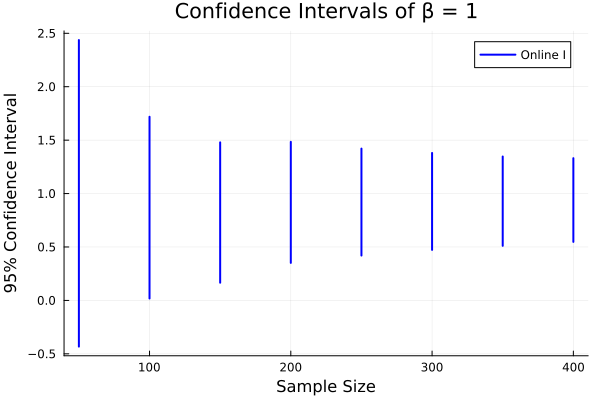

In [84]:
using Plots

# x축 좌표 생성
x_coords = 50:50:400

# 신뢰구간 데이터
CI_lower = mean_ci_interval_left_b1
CI_upper = mean_ci_interval_right_b1
#ci_data = n_100_result_dep[2][:, :, 4]

# 플롯 초기화
p = plot()

# 신뢰구간
for i in 1:length(CI_upper)
    lower_bound = CI_lower[i]
    upper_bound = CI_upper[i]
    
    if i == 1
        plot!(p, [x_coords[i], x_coords[i]], [lower_bound, upper_bound], label="Online I", color=:blue, linewidth=2)
    else
        plot!(p, [x_coords[i], x_coords[i]], [lower_bound, upper_bound], label=false, color=:blue, linewidth=2)
    end
end

# 플롯 설정 및 표시
xlabel!(p, "Sample Size")
ylabel!(p, "95% Confidence Interval")
title!(p, "Confidence Intervals of β = 1")
display(p)


#### n=400, p=2000, dep, s0 =10 / Online1_n400_p2000_dep_simnum10

In [61]:
n,p = 400,2000
s0 = 10
simnum = 10

b1 = 1:10
b01 = 11:20
b0 = 21:p


ci_interval_left = zeros(Float64, simnum,8,3)
ci_interval_right = zeros(Float64, simnum,8,3)
ci_interval_length = zeros(Float64, simnum,8,3)
times = zeros(Float64, simnum)
bias = zeros(Float64, simnum,8,3)
sds = zeros(Float64, simnum,8,3)
taus = zeros(Float64, simnum,8,3)

10×8×3 Array{Float64, 3}:
[:, :, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0

[:, :, 2] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0

[:, :, 3] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  

In [62]:
for seed in 1:simnum
    println(seed)
    
    X,y,β = dep_sampling(seed, n,p,s0)
    _, times[seed] = @timed begin
        b, tau_tilde_array, CI_left, CI_right = DSGD_calc_for_plot(0.0025, X, y, 0.05)
    end


    println(times[seed])
    bb = mapslices(x -> x.-β, b, dims = 2)
    ab = abs.(bb)
    
    println(mean(bb))
    
    for k in 1:8
        bias[seed,k,  1] = mean(ab[k,b1])
        bias[seed,k,  2] = mean(ab[k,b01])
        bias[seed,k,  3] = mean(ab[k,b0])
    
        sds[seed,k,1] = std(bb[k,b1])
        sds[seed,k,2] = std(bb[k,b01])
        sds[seed,k,3] = std(bb[k,b0])
    
        tau = tau_tilde_array
        taus[seed,k,1] = mean(tau[k,b1])
        taus[seed,k,2] = mean(tau[k,b01])
        taus[seed,k,3] = mean(tau[k,b0])
    
        CI_L = CI_left
        ci_interval_left[seed,k,1] = mean(CI_L[k,b1])
        ci_interval_left[seed,k,2] = mean(CI_L[k,b01])
        ci_interval_left[seed,k,3] = mean(CI_L[k,b0])
    
    
        CI_R = CI_right
        ci_interval_right[seed,k,1] = mean(CI_R[k,b1])
        ci_interval_right[seed,k,2] = mean(CI_R[k,b01])
        ci_interval_right[seed,k,3] = mean(CI_R[k,b0])
        
        CI_width = CI_right - CI_left
        ci_interval_length[seed,k,1] = mean(CI_width[k,b1])
        ci_interval_length[seed,k,2] = mean(CI_width[k,b01])
        ci_interval_length[seed,k,3] = mean(CI_width[k,b0])
    end

    
    # save_object("/Users/seungchanbaek/Downloads/2023-2학기/고급통계계산/Online1_n400_p2000_dep_simnum10/Online1_n400_p2000_dep_simnum10_time$seed", times[seed])
    # save_object("/Users/seungchanbaek/Downloads/2023-2학기/고급통계계산/Online1_n400_p2000_dep_simnum10/Online1_n400_p2000_dep_simnum10_bias$seed", bias[seed,:,:])
    # save_object("/Users/seungchanbaek/Downloads/2023-2학기/고급통계계산/Online1_n400_p2000_dep_simnum10/Online1_n400_p2000_dep_simnum10_sds$seed", sds[seed,:,:])
    # save_object("/Users/seungchanbaek/Downloads/2023-2학기/고급통계계산/Online1_n400_p2000_dep_simnum10/Online1_n400_p2000_dep_simnum10_taus$seed", taus[seed,:,:])

    # save_object("/Users/seungchanbaek/Downloads/2023-2학기/고급통계계산/Online1_n400_p2000_dep_simnum10/Online1_n400_p2000_dep_simnum10_ci_interval_length$seed", ci_interval_length[seed,:,:])
    # save_object("/Users/seungchanbaek/Downloads/2023-2학기/고급통계계산/Online1_n400_p2000_dep_simnum10/Online1_n400_p2000_dep_simnum10_ci_interval_left$seed", ci_interval_left[seed,:,:])
    # save_object("/Users/seungchanbaek/Downloads/2023-2학기/고급통계계산/Online1_n400_p2000_dep_simnum10/Online1_n400_p2000_dep_simnum10_ci_interval_right$seed", ci_interval_right[seed,:,:])
end


mean_bias_b1 = sum(bias[:,:,1], dims=1) / size(bias, 1)
mean_bias_b01 = sum(bias[:,:,2], dims=1) / size(bias, 1)
mean_bias_b0 = sum(bias[:,:,3], dims=1) / size(bias, 1)

mean_sds_b1 = sum(sds[:,:,1], dims=1) / size(sds, 1)
mean_sds_b01 = sum(sds[:,:,2], dims=1) / size(sds, 1)
mean_sds_b0 = sum(sds[:,:,3], dims=1) / size(sds, 1)


mean_taus_b1 = sum(taus[:,:,1], dims=1) / size(taus, 1)
mean_taus_b01 = sum(taus[:,:,2], dims=1) / size(taus, 1)
mean_taus_b0 = sum(taus[:,:,3], dims=1) / size(taus, 1)

mean_ci_interval_left_b1 = sum(ci_interval_left[:,:,1], dims=1) / size(ci_interval_left, 1)
mean_ci_interval_left_b01 = sum(ci_interval_left[:,:,2], dims=1) / size(ci_interval_left, 1)
mean_ci_interval_left_b0 = sum(ci_interval_left[:,:,3], dims=1) / size(ci_interval_left, 1)

mean_ci_interval_right_b1 = sum(ci_interval_right[:,:,1], dims=1) / size(ci_interval_right, 1)
mean_ci_interval_right_b01 = sum(ci_interval_right[:,:,2], dims=1) / size(ci_interval_right, 1)
mean_ci_interval_right_b0 = sum(ci_interval_right[:,:,3], dims=1) / size(ci_interval_right, 1)

mean_ci_interval_length_b1 = sum(ci_interval_length[:,:,1], dims=1) / size(ci_interval_length, 1)
mean_ci_interval_length_b01 = sum(ci_interval_length[:,:,2], dims=1) / size(ci_interval_length, 1)
mean_ci_interval_length_b0 = sum(ci_interval_length[:,:,3], dims=1) / size(ci_interval_length, 1)

mean_times = mean(times)

println("mean_bias_b1 : ", mean_bias_b1)
println("mean_bias_b01 : ", mean_bias_b01)
println("mean_bias_b0 : ", mean_bias_b0)

println("mean_sds_b1 : ", mean_sds_b1)
println("mean_sds_b01 : ", mean_sds_b01)
println("mean_sds_b0 : ", mean_sds_b0)

println("mean_taus_b1 : ", mean_taus_b1)
println("mean_taus_b01 : ", mean_taus_b01)
println("mean_taus_b0 : ", mean_taus_b0)

println("mean_ci_interval_left_b1 : ", mean_ci_interval_left_b1)
println("mean_ci_interval_left_b01 : ", mean_ci_interval_left_b01)
println("mean_ci_interval_left_b0 : ", mean_ci_interval_left_b0)

println("mean_ci_interval_right_b1 : ", mean_ci_interval_right_b1)
println("mean_ci_interval_right_b01 : ", mean_ci_interval_right_b01)
println("mean_ci_interval_right_b0 : ", mean_ci_interval_right_b0)

println("mean_ci_interval_length_b1 : ", mean_ci_interval_length_b1)
println("mean_ci_interval_length_b01 : ", mean_ci_interval_length_b01)
println("mean_ci_interval_length_b0 : ", mean_ci_interval_length_b0)

println("mean_times : ", mean_times)

1


96.293398494


0.2961045942540776
2


112.932728737
-0.06532578003819979
3


115.357523119
-0.035400218107225837
4


115.991095115
0.23634856304061638
5


119.301024957
0.5639833058043086
6


115.35940202
0.5227776890286016
7


110.320642413
0.24281387940098217
8


120.202739252
-0.06588537268759143
9


119.845370349
0.31838616216714627
10


110.928597528
-0.062084321160011696
mean_bias_b1 : [1.8837602097778317 1.0713416385647097 1.0081129560056041 0.9708513600115175 1.0602808111928164 1.105184707402335 1.1122501956999076 1.1270903801468415]
mean_bias_b01 : [1.9768158151223254 0.8093740233427266 0.5661525739705819 0.52441098744391 0.5595388217996359 0.5155833788643498 0.4767267065371463 0.49241926690479365]
mean_bias_b0 : [1.589359247271108 0.5872045954840226 0.4348057853292814 0.3583386616647127 0.3572695458353531 0.34070287289921847 0.31435438453040654 0.31969220064625564]
mean_sds_b1 : [2.355616505925765 0.6113401786941578 0.4279759832825302 0.3477197565360371 0.2839910574116701 0.2876736308486666 0.27961123409678457 0.26538109933138276]
mean_sds_b01 : [2.9465312493662554 0.6676399536852858 0.3833677446097322 0.3132754382809195 0.3115405336429323 0.28423672152357826 0.302212372580274 0.2795816969506335]
mean_sds_b0 : [8.946563354502214 0.6937446153577937 0.43640363665655235 0.3375680568053796 0.2846744100836518 0.253350

#### n=100, p=400, dep, s0 =3 / Online1_n100_p400_dep_simnum10

In [21]:
n,p = 100,400
s0 = 3
simnum = 10

b1 = 1:3
b01 = 4:6
b0 = 7:p

num_save_points = 3
ci_interval_left = zeros(Float64, simnum,num_save_points,3)
ci_interval_right = zeros(Float64, simnum,num_save_points,3)
ci_interval_length = zeros(Float64, simnum,num_save_points,3)
times = zeros(Float64, simnum)
bias = zeros(Float64, simnum,num_save_points,3)
sds = zeros(Float64, simnum,num_save_points,3)
taus = zeros(Float64, simnum,num_save_points,3)

10×3×3 Array{Float64, 3}:
[:, :, 1] =
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0

[:, :, 2] =
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0

[:, :, 3] =
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0

In [44]:
for seed in 1:simnum
    println(seed)
    
    X,y,β = dep_sampling(seed, n,p,s0)
    _, times[seed] = @timed begin
        b, tau_tilde_array, CI_left, CI_right = DSGD_calc_for_plot(0.0025, X, y, 0.05)
    end


    println(times[seed])
    bb = mapslices(x -> x.-β, b, dims = 2)
    ab = abs.(bb)
    
    println(mean(bb))
    
    for k in 1:num_save_points
        bias[seed,k,  1] = mean(ab[k,b1])
        bias[seed,k,  2] = mean(ab[k,b01])
        bias[seed,k,  3] = mean(ab[k,b0])
    
        sds[seed,k,1] = std(bb[k,b1])
        sds[seed,k,2] = std(bb[k,b01])
        sds[seed,k,3] = std(bb[k,b0])
    
        tau = tau_tilde_array
        taus[seed,k,1] = mean(tau[k,b1])
        taus[seed,k,2] = mean(tau[k,b01])
        taus[seed,k,3] = mean(tau[k,b0])
    
        CI_L = CI_left
        ci_interval_left[seed,k,1] = mean(CI_L[k,b1])
        ci_interval_left[seed,k,2] = mean(CI_L[k,b01])
        ci_interval_left[seed,k,3] = mean(CI_L[k,b0])
    
    
        CI_R = CI_right
        ci_interval_right[seed,k,1] = mean(CI_R[k,b1])
        ci_interval_right[seed,k,2] = mean(CI_R[k,b01])
        ci_interval_right[seed,k,3] = mean(CI_R[k,b0])
        
        CI_width = CI_right - CI_left
        ci_interval_length[seed,k,1] = mean(CI_width[k,b1])
        ci_interval_length[seed,k,2] = mean(CI_width[k,b01])
        ci_interval_length[seed,k,3] = mean(CI_width[k,b0])
    end


    
    # save_object("/Users/seungchanbaek/Downloads/2023-2학기/고급통계계산/Online1_n100_p400_dep_simnum10/Online1_n100_p400_dep_simnum10_time$seed", times[seed])
    # save_object("/Users/seungchanbaek/Downloads/2023-2학기/고급통계계산/Online1_n100_p400_dep_simnum10/Online1_n100_p400_dep_simnum10_bias$seed", bias[seed,:,:])
    # save_object("/Users/seungchanbaek/Downloads/2023-2학기/고급통계계산/Online1_n100_p400_dep_simnum10/Online1_n100_p400_dep_simnum10_sds$seed", sds[seed,:,:])
    # save_object("/Users/seungchanbaek/Downloads/2023-2학기/고급통계계산/Online1_n100_p400_dep_simnum10/Online1_n100_p400_dep_simnum10_taus$seed", taus[seed,:,:])

    # save_object("/Users/seungchanbaek/Downloads/2023-2학기/고급통계계산/Online1_n100_p400_dep_simnum10/Online1_n100_p400_dep_simnum10_ci_interval_length$seed", ci_interval_length[seed,:,:])
    # save_object("/Users/seungchanbaek/Downloads/2023-2학기/고급통계계산/Online1_n100_p400_dep_simnum10/Online1_n100_p400_dep_simnum10_ci_interval_left$seed", ci_interval_left[seed,:,:])
    # save_object("/Users/seungchanbaek/Downloads/2023-2학기/고급통계계산/Online1_n100_p400_dep_simnum10/Online1_n100_p400_dep_simnum10_ci_interval_right$seed", ci_interval_right[seed,:,:])
end

mean_bias_b1 = sum(bias[:,:,1], dims=1) / size(bias, 1)
mean_bias_b01 = sum(bias[:,:,2], dims=1) / size(bias, 1)
mean_bias_b0 = sum(bias[:,:,3], dims=1) / size(bias, 1)

mean_sds_b1 = sum(sds[:,:,1], dims=1) / size(sds, 1)
mean_sds_b01 = sum(sds[:,:,2], dims=1) / size(sds, 1)
mean_sds_b0 = sum(sds[:,:,3], dims=1) / size(sds, 1)


mean_taus_b1 = sum(taus[:,:,1], dims=1) / size(taus, 1)
mean_taus_b01 = sum(taus[:,:,2], dims=1) / size(taus, 1)
mean_taus_b0 = sum(taus[:,:,3], dims=1) / size(taus, 1)

mean_ci_interval_left_b1 = sum(ci_interval_left[:,:,1], dims=1) / size(ci_interval_left, 1)
mean_ci_interval_left_b01 = sum(ci_interval_left[:,:,2], dims=1) / size(ci_interval_left, 1)
mean_ci_interval_left_b0 = sum(ci_interval_left[:,:,3], dims=1) / size(ci_interval_left, 1)

mean_ci_interval_right_b1 = sum(ci_interval_right[:,:,1], dims=1) / size(ci_interval_right, 1)
mean_ci_interval_right_b01 = sum(ci_interval_right[:,:,2], dims=1) / size(ci_interval_right, 1)
mean_ci_interval_right_b0 = sum(ci_interval_right[:,:,3], dims=1) / size(ci_interval_right, 1)

mean_ci_interval_length_b1 = sum(ci_interval_length[:,:,1], dims=1) / size(ci_interval_length, 1)
mean_ci_interval_length_b01 = sum(ci_interval_length[:,:,2], dims=1) / size(ci_interval_length, 1)
mean_ci_interval_length_b0 = sum(ci_interval_length[:,:,3], dims=1) / size(ci_interval_length, 1)

mean_times = mean(times)

println("mean_bias_b1 : ", mean_bias_b1)
println("mean_bias_b01 : ", mean_bias_b01)
println("mean_bias_b0 : ", mean_bias_b0)

println("mean_sds_b1 : ", mean_sds_b1)
println("mean_sds_b01 : ", mean_sds_b01)
println("mean_sds_b0 : ", mean_sds_b0)

println("mean_taus_b1 : ", mean_taus_b1)
println("mean_taus_b01 : ", mean_taus_b01)
println("mean_taus_b0 : ", mean_taus_b0)

println("mean_ci_interval_left_b1 : ", mean_ci_interval_left_b1)
println("mean_ci_interval_left_b01 : ", mean_ci_interval_left_b01)
println("mean_ci_interval_left_b0 : ", mean_ci_interval_left_b0)

println("mean_ci_interval_right_b1 : ", mean_ci_interval_right_b1)
println("mean_ci_interval_right_b01 : ", mean_ci_interval_right_b01)
println("mean_ci_interval_right_b0 : ", mean_ci_interval_right_b0)

println("mean_ci_interval_length_b1 : ", mean_ci_interval_length_b1)
println("mean_ci_interval_length_b01 : ", mean_ci_interval_length_b01)
println("mean_ci_interval_length_b0 : ", mean_ci_interval_length_b0)

println("mean_times : ", mean_times)


1


1.204248859


0.08889753911653149
2


1.209023923
0.0003526684056533617
3


1.238831531
0.16830619832546648
4


1.211728806
-0.006990108434237744
5


1.201212228
-0.07960519895589235
6


1.2335737
0.14669905196632063
7


1.246757908
0.09143867069935578
8


1.396760256
-0.03986064544668559
9


1.502077021
0.05429689571148536
10


1.193887966
0.032753812786739125
mean_bias_b1 : 

[0.6122687278320413 0.6974538773296102 0.7088433267464069]
mean_bias_b01 : [0.5661477976594541 0.5404188141191932 0.5266820892278566]
mean_bias_b0 : [0.29990406765871813 0.23310920691790032 0.1940634975428338]
mean_sds_b1 : [0.20848063140400447 0.16144291207346473 0.14802150504425088]
mean_sds_b01 : [0.37240953612560224 0.36244848297213883 0.3102204106061507]
mean_sds_b0 : [0.3614984830733826 0.2768726852906228 0.22555509451007838]
mean_taus_b1 : [0.02589684168815675 0.01467654180795871 0.010405509354510782]
mean_taus_b01 : [0.02631288685885149 0.01485905392853135 0.010359669384000424]
mean_taus_b0 : [0.026231183521906842 0.014867333189397916 0.010390402413746516]
mean_ci_interval_left_b1 : [1.4799633572830184 1.6247504348014268 1.6576211208177516]
mean_ci_interval_left_b01 : [0.49106588428501574 0.5471435637105089 0.5756722618556946]
mean_ci_interval_left_b0 : [-0.08909333172029245 -0.027328034527422645 -0.023708855503967258]
mean_ci_interval_right_b1 : [1.7302161167141563 1.770157319

In [46]:
mean(times)

1.2638102198

In [37]:
bias

10×3×3 Array{Float64, 3}:
[:, :, 1] =
 0.532453  0.571853  0.541241
 0.701656  0.964926  0.876814
 0.873161  0.835008  0.857096
 0.424859  0.597735  0.913707
 0.181731  0.266282  0.294812
 0.633579  0.667443  0.69726
 0.659069  0.69719   0.620707
 0.761051  0.651935  0.642093
 0.838924  0.98529   0.776856
 0.516205  0.736878  0.867848

[:, :, 2] =
 0.563314  0.464473  0.359372
 0.450044  0.427089  0.530968
 0.785301  0.744351  0.691414
 0.293252  0.441427  0.587078
 0.291038  0.240217  0.321319
 0.764113  0.729868  0.592841
 0.737553  0.744661  0.689583
 0.509348  0.495186  0.426834
 0.909377  0.837813  0.742865
 0.358138  0.279104  0.324547

[:, :, 3] =
 0.290382  0.257473  0.178253
 0.292221  0.231046  0.179824
 0.340964  0.246577  0.223611
 0.287377  0.220784  0.210112
 0.248189  0.213285  0.18989
 0.30272   0.233544  0.210134
 0.292465  0.21425   0.165391
 0.341137  0.236186  0.186366
 0.331546  0.260942  0.211489
 0.272041  0.217006  0.185565

In [35]:
#(bias[1,:,1] + bias[2,:,1] + ... + bias[10,:,1])/10
bias[:,:,1]

mean_bias_b1 = sum(bias[:,:,1], dims=1) / size(bias, 1)
mean_bias_b01 = sum(bias[:,:,2], dims=1) / size(bias, 1)
mean_bias_b0 = sum(bias[:,:,3], dims=1) / size(bias, 1)

1×3 Matrix{Float64}:
 0.299904  0.233109  0.194063

In [43]:
mean_bias_b1

1×3 Matrix{Float64}:
 0.612269  0.697454  0.708843

#### n=100, p=400, ind, s0 =3 / Online1_n100_p400_ind_simnum10

In [48]:
n,p = 100,400
s0 = 3
simnum = 10

b1 = 1:3
b01 = 4:6
b0 = 7:p

num_save_points = 3
ci_interval_left = zeros(Float64, simnum,num_save_points,3)
ci_interval_right = zeros(Float64, simnum,num_save_points,3)
ci_interval_length = zeros(Float64, simnum,num_save_points,3)
times = zeros(Float64, simnum)
bias = zeros(Float64, simnum,num_save_points,3)
sds = zeros(Float64, simnum,num_save_points,3)
taus = zeros(Float64, simnum,num_save_points,3)

10×3×3 Array{Float64, 3}:
[:, :, 1] =
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0

[:, :, 2] =
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0

[:, :, 3] =
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0

In [49]:
for seed in 1:simnum
    println(seed)
    
    X,y,β = indep_sampling(seed, n,p,s0)
    _, times[seed] = @timed begin
        b, tau_tilde_array, CI_left, CI_right = DSGD_calc_for_plot(0.0025, X, y, 0.05)
    end


    println(times[seed])
    bb = mapslices(x -> x.-β, b, dims = 2)
    ab = abs.(bb)
    
    println(mean(bb))
    
    for k in 1:num_save_points
        bias[seed,k,  1] = mean(ab[k,b1])
        bias[seed,k,  2] = mean(ab[k,b01])
        bias[seed,k,  3] = mean(ab[k,b0])
    
        sds[seed,k,1] = std(bb[k,b1])
        sds[seed,k,2] = std(bb[k,b01])
        sds[seed,k,3] = std(bb[k,b0])
    
        tau = tau_tilde_array
        taus[seed,k,1] = mean(tau[k,b1])
        taus[seed,k,2] = mean(tau[k,b01])
        taus[seed,k,3] = mean(tau[k,b0])
    
        CI_L = CI_left
        ci_interval_left[seed,k,1] = mean(CI_L[k,b1])
        ci_interval_left[seed,k,2] = mean(CI_L[k,b01])
        ci_interval_left[seed,k,3] = mean(CI_L[k,b0])
    
    
        CI_R = CI_right
        ci_interval_right[seed,k,1] = mean(CI_R[k,b1])
        ci_interval_right[seed,k,2] = mean(CI_R[k,b01])
        ci_interval_right[seed,k,3] = mean(CI_R[k,b0])
        
        CI_width = CI_right - CI_left
        ci_interval_length[seed,k,1] = mean(CI_width[k,b1])
        ci_interval_length[seed,k,2] = mean(CI_width[k,b01])
        ci_interval_length[seed,k,3] = mean(CI_width[k,b0])
    end

    
    # save_object("/Users/seungchanbaek/Downloads/2023-2학기/고급통계계산/Online1_n100_p400_ind_simnum10/Online1_n100_p400_ind_simnum10_time$seed", times[seed])
    # save_object("/Users/seungchanbaek/Downloads/2023-2학기/고급통계계산/Online1_n100_p400_ind_simnum10/Online1_n100_p400_ind_simnum10_bias$seed", bias[seed,:,:])
    # save_object("/Users/seungchanbaek/Downloads/2023-2학기/고급통계계산/Online1_n100_p400_ind_simnum10/Online1_n100_p400_ind_simnum10_sds$seed", sds[seed,:,:])
    # save_object("/Users/seungchanbaek/Downloads/2023-2학기/고급통계계산/Online1_n100_p400_ind_simnum10/Online1_n100_p400_ind_simnum10_taus$seed", taus[seed,:,:])

    # save_object("/Users/seungchanbaek/Downloads/2023-2학기/고급통계계산/Online1_n100_p400_ind_simnum10/Online1_n100_p400_ind_simnum10_ci_interval_length$seed", ci_interval_length[seed,:,:])
    # save_object("/Users/seungchanbaek/Downloads/2023-2학기/고급통계계산/Online1_n100_p400_ind_simnum10/Online1_n100_p400_ind_simnum10_ci_interval_left$seed", ci_interval_left[seed,:,:])
    # save_object("/Users/seungchanbaek/Downloads/2023-2학기/고급통계계산/Online1_n100_p400_ind_simnum10/Online1_n100_p400_ind_simnum10_ci_interval_right$seed", ci_interval_right[seed,:,:])

end


mean_bias_b1 = sum(bias[:,:,1], dims=1) / size(bias, 1)
mean_bias_b01 = sum(bias[:,:,2], dims=1) / size(bias, 1)
mean_bias_b0 = sum(bias[:,:,3], dims=1) / size(bias, 1)

mean_sds_b1 = sum(sds[:,:,1], dims=1) / size(sds, 1)
mean_sds_b01 = sum(sds[:,:,2], dims=1) / size(sds, 1)
mean_sds_b0 = sum(sds[:,:,3], dims=1) / size(sds, 1)


mean_taus_b1 = sum(taus[:,:,1], dims=1) / size(taus, 1)
mean_taus_b01 = sum(taus[:,:,2], dims=1) / size(taus, 1)
mean_taus_b0 = sum(taus[:,:,3], dims=1) / size(taus, 1)

mean_ci_interval_left_b1 = sum(ci_interval_left[:,:,1], dims=1) / size(ci_interval_left, 1)
mean_ci_interval_left_b01 = sum(ci_interval_left[:,:,2], dims=1) / size(ci_interval_left, 1)
mean_ci_interval_left_b0 = sum(ci_interval_left[:,:,3], dims=1) / size(ci_interval_left, 1)

mean_ci_interval_right_b1 = sum(ci_interval_right[:,:,1], dims=1) / size(ci_interval_right, 1)
mean_ci_interval_right_b01 = sum(ci_interval_right[:,:,2], dims=1) / size(ci_interval_right, 1)
mean_ci_interval_right_b0 = sum(ci_interval_right[:,:,3], dims=1) / size(ci_interval_right, 1)

mean_ci_interval_length_b1 = sum(ci_interval_length[:,:,1], dims=1) / size(ci_interval_length, 1)
mean_ci_interval_length_b01 = sum(ci_interval_length[:,:,2], dims=1) / size(ci_interval_length, 1)
mean_ci_interval_length_b0 = sum(ci_interval_length[:,:,3], dims=1) / size(ci_interval_length, 1)

mean_times = mean(times)

println("mean_bias_b1 : ", mean_bias_b1)
println("mean_bias_b01 : ", mean_bias_b01)
println("mean_bias_b0 : ", mean_bias_b0)

println("mean_sds_b1 : ", mean_sds_b1)
println("mean_sds_b01 : ", mean_sds_b01)
println("mean_sds_b0 : ", mean_sds_b0)

println("mean_taus_b1 : ", mean_taus_b1)
println("mean_taus_b01 : ", mean_taus_b01)
println("mean_taus_b0 : ", mean_taus_b0)

println("mean_ci_interval_left_b1 : ", mean_ci_interval_left_b1)
println("mean_ci_interval_left_b01 : ", mean_ci_interval_left_b01)
println("mean_ci_interval_left_b0 : ", mean_ci_interval_left_b0)

println("mean_ci_interval_right_b1 : ", mean_ci_interval_right_b1)
println("mean_ci_interval_right_b01 : ", mean_ci_interval_right_b01)
println("mean_ci_interval_right_b0 : ", mean_ci_interval_right_b0)

println("mean_ci_interval_length_b1 : ", mean_ci_interval_length_b1)
println("mean_ci_interval_length_b01 : ", mean_ci_interval_length_b01)
println("mean_ci_interval_length_b0 : ", mean_ci_interval_length_b0)

println("mean_times : ", mean_times)


1


1.944382466


-0.03664158332649123
2


1.174224794
0.04156734472327117
3


1.18051604
-0.018081777978714766
4


1.18546372
0.021681434263550046
5


1.241942191
0.02508271009047561
6


1.142953157
0.038694022025631464
7


1.187017986
0.010335156688180181
8


1.308865996
-0.025072582286048747
9


1.443264938
-0.01267928574801191
10


1.134007489
-0.02213098503486593
mean_bias_b1 : [0.2725178965329507 0.1999591818645351 0.16088512681766876]
mean_bias_b01 : [0.19991495884444335 0.17629219201631352 0.1495248627327492]
mean_bias_b0 : [0.2229917976912487 0.1723292586743998 0.1443428517386735]
mean_sds_b1 : [0.1687175709151881 0.11726983863472935 0.06726841298868395]
mean_sds_b01 : [0.23510542217579733 0.20905189592039405 0.18664451463650011]
mean_sds_b0 : [0.2760684270052852 0.21308278145086174 0.17845428277694014]
mean_taus_b1 : [0.02598447193453247 0.014476864840923559 0.010232653582925261]
mean_taus_b01 : [0.025598428839035257 0.014686517141283342 0.010256103198596834]
mean_taus_b0 : [0.02601267814186663 0.014667971376238514 0.010216236283285298]
mean_ci_interval_left_b1 : [0.6809955259722399 0.7829558965991231 0.8446746987046024]
mean_ci_interval_left_b01 : [0.04320078568006739 0.08354804327191002 0.07839361026113344]
mean_ci_interval_left_b0 : [-0.08600435124789912 -0.05397905060072309 -0.035093398249749844]
mean_c

#### n=100000, p=10, ind, s0 =3 / Online1_n100000_p10_ind_simnum10

In [50]:
n,p = 100000,10
simnum = 10

b1 = 1:3
b01 = 4:6
b0 = 7:p

ci_interval_left = zeros(Float64, simnum,3)
ci_interval_right = zeros(Float64, simnum,3)
ci_interval_length = zeros(Float64, simnum,3)
times = zeros(Float64, simnum)
bias = zeros(Float64, simnum,3)
sds = zeros(Float64, simnum,3)
taus = zeros(Float64, simnum,3)


10×3 Matrix{Float64}:
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0

In [51]:
for seed in 1:simnum
    println(seed)
    
    X,y,β = indep_sampling(seed, n,p,3)
    _, times[seed] = @timed begin
        b, tau_tilde_array, CI_left, CI_right = DSGD_calc_onlyfinal(0.0025, X, y, 0.05)
    end


    println(times[seed])
    bb = b .- β
    ab = abs.(bb)
    
    println(mean(bb))
    

    bias[seed,  1] = mean(ab[b1])
    bias[seed,  2] = mean(ab[b01])
    bias[seed,  3] = mean(ab[b0])

    sds[seed,1] = std(bb[b1])
    sds[seed,2] = std(bb[b01])
    sds[seed,3] = std(bb[b0])

    tau = tau_tilde_array
    taus[seed,1] = mean(tau[b1])
    taus[seed,2] = mean(tau[b01])
    taus[seed,3] = mean(tau[b0])

    CI_L = CI_left
    ci_interval_left[seed,1] = mean(CI_L[b1])
    ci_interval_left[seed,2] = mean(CI_L[b01])
    ci_interval_left[seed,3] = mean(CI_L[b0])


    CI_R = CI_right
    ci_interval_right[seed,1] = mean(CI_R[b1])
    ci_interval_right[seed,2] = mean(CI_R[b01])
    ci_interval_right[seed,3] = mean(CI_R[b0])
    
    CI_width = CI_right - CI_left
    ci_interval_length[seed,1] = mean(CI_width[b1])
    ci_interval_length[seed,2] = mean(CI_width[b01])
    ci_interval_length[seed,3] = mean(CI_width[b0])

    
    # save_object("/Users/seungchanbaek/Downloads/2023-2학기/고급통계계산/Online1_n100000_p10_ind_simnum10/Online1_n100000_p10_ind_simnum10_time$seed", times[seed])
    # save_object("/Users/seungchanbaek/Downloads/2023-2학기/고급통계계산/Online1_n100000_p10_ind_simnum10/Online1_n100000_p10_ind_simnum10_bias$seed", bias[seed,:])
    # save_object("/Users/seungchanbaek/Downloads/2023-2학기/고급통계계산/Online1_n100000_p10_ind_simnum10/Online1_n100000_p10_ind_simnum10_sds$seed", sds[seed,:])
    # save_object("/Users/seungchanbaek/Downloads/2023-2학기/고급통계계산/Online1_n100000_p10_ind_simnum10/Online1_n100000_p10_ind_simnum10_taus$seed", taus[seed,:])

    # save_object("/Users/seungchanbaek/Downloads/2023-2학기/고급통계계산/Online1_n100000_p10_ind_simnum10/Online1_n100000_p10_ind_simnum10_ci_interval_length$seed", ci_interval_length[seed,:])
    # save_object("/Users/seungchanbaek/Downloads/2023-2학기/고급통계계산/Online1_n100000_p10_ind_simnum10/Online1_n100000_p10_ind_simnum10_ci_interval_left$seed", ci_interval_left[seed,:])
    # save_object("/Users/seungchanbaek/Downloads/2023-2학기/고급통계계산/Online1_n100000_p10_ind_simnum10/Online1_n100000_p10_ind_simnum10_ci_interval_right$seed", ci_interval_right[seed,:])
end

mean_bias_b1 = sum(bias[:,1], dims=1) / size(bias, 1)
mean_bias_b01 = sum(bias[:,2], dims=1) / size(bias, 1)
mean_bias_b0 = sum(bias[:,3], dims=1) / size(bias, 1)

mean_sds_b1 = sum(sds[:,1], dims=1) / size(sds, 1)
mean_sds_b01 = sum(sds[:,2], dims=1) / size(sds, 1)
mean_sds_b0 = sum(sds[:,3], dims=1) / size(sds, 1)


mean_taus_b1 = sum(taus[:,1], dims=1) / size(taus, 1)
mean_taus_b01 = sum(taus[:,2], dims=1) / size(taus, 1)
mean_taus_b0 = sum(taus[:,3], dims=1) / size(taus, 1)

mean_ci_interval_left_b1 = sum(ci_interval_left[:,1], dims=1) / size(ci_interval_left, 1)
mean_ci_interval_left_b01 = sum(ci_interval_left[:,2], dims=1) / size(ci_interval_left, 1)
mean_ci_interval_left_b0 = sum(ci_interval_left[:,3], dims=1) / size(ci_interval_left, 1)

mean_ci_interval_right_b1 = sum(ci_interval_right[:,1], dims=1) / size(ci_interval_right, 1)
mean_ci_interval_right_b01 = sum(ci_interval_right[:,2], dims=1) / size(ci_interval_right, 1)
mean_ci_interval_right_b0 = sum(ci_interval_right[:,3], dims=1) / size(ci_interval_right, 1)

mean_ci_interval_length_b1 = sum(ci_interval_length[:,1], dims=1) / size(ci_interval_length, 1)
mean_ci_interval_length_b01 = sum(ci_interval_length[:,2], dims=1) / size(ci_interval_length, 1)
mean_ci_interval_length_b0 = sum(ci_interval_length[:,3], dims=1) / size(ci_interval_length, 1)

mean_times = mean(times)

println("mean_bias_b1 : ", mean_bias_b1)
println("mean_bias_b01 : ", mean_bias_b01)
println("mean_bias_b0 : ", mean_bias_b0)

println("mean_sds_b1 : ", mean_sds_b1)
println("mean_sds_b01 : ", mean_sds_b01)
println("mean_sds_b0 : ", mean_sds_b0)

println("mean_taus_b1 : ", mean_taus_b1)
println("mean_taus_b01 : ", mean_taus_b01)
println("mean_taus_b0 : ", mean_taus_b0)

println("mean_ci_interval_left_b1 : ", mean_ci_interval_left_b1)
println("mean_ci_interval_left_b01 : ", mean_ci_interval_left_b01)
println("mean_ci_interval_left_b0 : ", mean_ci_interval_left_b0)

println("mean_ci_interval_right_b1 : ", mean_ci_interval_right_b1)
println("mean_ci_interval_right_b01 : ", mean_ci_interval_right_b01)
println("mean_ci_interval_right_b0 : ", mean_ci_interval_right_b0)

println("mean_ci_interval_length_b1 : ", mean_ci_interval_length_b1)
println("mean_ci_interval_length_b01 : ", mean_ci_interval_length_b01)
println("mean_ci_interval_length_b0 : ", mean_ci_interval_length_b0)

println("mean_times : ", mean_times)


1


2.511368004


0.007745532944443247


2


2.07224973
0.010147629346824996
3


2.279453342
0.010516123791189219
4


1.898450501
0.01231233145714572
5


1.814041137
0.009374030199098427
6


1.903743785
0.012276494701221843
7


2.132624388
0.0071939598095128055
8


2.208270555
0.011120971371037357
9


1.926827034
0.009143198867662381
10


2.000436097
0.01016694052594384


mean_bias_b1 : 

[0.008790417341758672]
mean_bias_b01 : [0.009857333925811756]
mean_bias_b0 : [0.011236756011674023]
mean_sds_b1 : [0.0028293428502258198]
mean_sds_b01 : [0.005130782351100903]
mean_sds_b0 : [0.003358238567563979]
mean_taus_b1 : [1.000374099968082e-5]
mean_taus_b01 : [1.0003490988500463e-5]
mean_taus_b0 : [1.0003487096021858e-5]
mean_ci_interval_left_b1 : [1.0087625924517631]
mean_ci_interval_left_b01 : [0.1095318214586477]
mean_ci_interval_left_b0 : [0.011208931838703338]
mean_ci_interval_right_b1 : [1.0088182422317544]
mean_ci_interval_right_b01 : [0.10958746983609077]
mean_ci_interval_right_b0 : [0.011264580184644707]
mean_ci_interval_length_b1 : [5.564977999091465e-5]
mean_ci_interval_length_b01 : [5.5648377443057176e-5]
mean_ci_interval_length_b0 : [5.564834594136586e-5]
mean_times : 2.0747464573


#### n=100000, p=10, dep, s0 =3 / Online1_n100000_p10_dep_simnum10

In [52]:
n,p = 100000,10
simnum = 10

b1 = 1:3
b01 = 4:6
b0 = 7:p

ci_interval_left = zeros(Float64, simnum,3)
ci_interval_right = zeros(Float64, simnum,3)
ci_interval_length = zeros(Float64, simnum,3)
times = zeros(Float64, simnum)
bias = zeros(Float64, simnum,3)
sds = zeros(Float64, simnum,3)
taus = zeros(Float64, simnum,3)

10×3 Matrix{Float64}:
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0

In [54]:
for seed in 1:simnum
    println(seed)
    
    X,y,β = dep_sampling(seed, n,p,3)
    _, times[seed] = @timed begin
        b, tau_tilde_array, CI_left, CI_right = DSGD_calc_onlyfinal(0.0025, X, y, 0.05)
    end


    println(times[seed])
    bb = b .- β
    ab = abs.(bb)
    
    println(mean(bb))
    

    bias[seed,  1] = mean(ab[b1])
    bias[seed,  2] = mean(ab[b01])
    bias[seed,  3] = mean(ab[b0])

    sds[seed,1] = std(bb[b1])
    sds[seed,2] = std(bb[b01])
    sds[seed,3] = std(bb[b0])

    tau = tau_tilde_array
    taus[seed,1] = mean(tau[b1])
    taus[seed,2] = mean(tau[b01])
    taus[seed,3] = mean(tau[b0])

    CI_L = CI_left
    ci_interval_left[seed,1] = mean(CI_L[b1])
    ci_interval_left[seed,2] = mean(CI_L[b01])
    ci_interval_left[seed,3] = mean(CI_L[b0])


    CI_R = CI_right
    ci_interval_right[seed,1] = mean(CI_R[b1])
    ci_interval_right[seed,2] = mean(CI_R[b01])
    ci_interval_right[seed,3] = mean(CI_R[b0])
    
    CI_width = CI_right - CI_left
    ci_interval_length[seed,1] = mean(CI_width[b1])
    ci_interval_length[seed,2] = mean(CI_width[b01])
    ci_interval_length[seed,3] = mean(CI_width[b0])

    
    # save_object("/Users/seungchanbaek/Downloads/2023-2학기/고급통계계산/Online1_n100000_p10_dep_simnum10/Online1_n100000_p10_dep_simnum10_time$seed", times[seed])
    # save_object("/Users/seungchanbaek/Downloads/2023-2학기/고급통계계산/Online1_n100000_p10_dep_simnum10/Online1_n100000_p10_dep_simnum10_bias$seed", bias[seed,:])
    # save_object("/Users/seungchanbaek/Downloads/2023-2학기/고급통계계산/Online1_n100000_p10_dep_simnum10/Online1_n100000_p10_dep_simnum10_sds$seed", sds[seed,:])
    # save_object("/Users/seungchanbaek/Downloads/2023-2학기/고급통계계산/Online1_n100000_p10_dep_simnum10/Online1_n100000_p10_dep_simnum10_taus$seed", taus[seed,:])

    # save_object("/Users/seungchanbaek/Downloads/2023-2학기/고급통계계산/Online1_n100000_p10_dep_simnum10/Online1_n100000_p10_dep_simnum10_ci_interval_length$seed", ci_interval_length[seed,:])
    # save_object("/Users/seungchanbaek/Downloads/2023-2학기/고급통계계산/Online1_n100000_p10_dep_simnum10/Online1_n100000_p10_dep_simnum10_ci_interval_left$seed", ci_interval_left[seed,:])
    # save_object("/Users/seungchanbaek/Downloads/2023-2학기/고급통계계산/Online1_n100000_p10_dep_simnum10/Online1_n100000_p10_dep_simnum10_ci_interval_right$seed", ci_interval_right[seed,:])

end


mean_bias_b1 = sum(bias[:,1], dims=1) / size(bias, 1)
mean_bias_b01 = sum(bias[:,2], dims=1) / size(bias, 1)
mean_bias_b0 = sum(bias[:,3], dims=1) / size(bias, 1)

mean_sds_b1 = sum(sds[:,1], dims=1) / size(sds, 1)
mean_sds_b01 = sum(sds[:,2], dims=1) / size(sds, 1)
mean_sds_b0 = sum(sds[:,3], dims=1) / size(sds, 1)


mean_taus_b1 = sum(taus[:,1], dims=1) / size(taus, 1)
mean_taus_b01 = sum(taus[:,2], dims=1) / size(taus, 1)
mean_taus_b0 = sum(taus[:,3], dims=1) / size(taus, 1)

mean_ci_interval_left_b1 = sum(ci_interval_left[:,1], dims=1) / size(ci_interval_left, 1)
mean_ci_interval_left_b01 = sum(ci_interval_left[:,2], dims=1) / size(ci_interval_left, 1)
mean_ci_interval_left_b0 = sum(ci_interval_left[:,3], dims=1) / size(ci_interval_left, 1)

mean_ci_interval_right_b1 = sum(ci_interval_right[:,1], dims=1) / size(ci_interval_right, 1)
mean_ci_interval_right_b01 = sum(ci_interval_right[:,2], dims=1) / size(ci_interval_right, 1)
mean_ci_interval_right_b0 = sum(ci_interval_right[:,3], dims=1) / size(ci_interval_right, 1)

mean_ci_interval_length_b1 = sum(ci_interval_length[:,1], dims=1) / size(ci_interval_length, 1)
mean_ci_interval_length_b01 = sum(ci_interval_length[:,2], dims=1) / size(ci_interval_length, 1)
mean_ci_interval_length_b0 = sum(ci_interval_length[:,3], dims=1) / size(ci_interval_length, 1)

mean_times = mean(times)

println("mean_bias_b1 : ", mean_bias_b1)
println("mean_bias_b01 : ", mean_bias_b01)
println("mean_bias_b0 : ", mean_bias_b0)

println("mean_sds_b1 : ", mean_sds_b1)
println("mean_sds_b01 : ", mean_sds_b01)
println("mean_sds_b0 : ", mean_sds_b0)

println("mean_taus_b1 : ", mean_taus_b1)
println("mean_taus_b01 : ", mean_taus_b01)
println("mean_taus_b0 : ", mean_taus_b0)

println("mean_ci_interval_left_b1 : ", mean_ci_interval_left_b1)
println("mean_ci_interval_left_b01 : ", mean_ci_interval_left_b01)
println("mean_ci_interval_left_b0 : ", mean_ci_interval_left_b0)

println("mean_ci_interval_right_b1 : ", mean_ci_interval_right_b1)
println("mean_ci_interval_right_b01 : ", mean_ci_interval_right_b01)
println("mean_ci_interval_right_b0 : ", mean_ci_interval_right_b0)

println("mean_ci_interval_length_b1 : ", mean_ci_interval_length_b1)
println("mean_ci_interval_length_b01 : ", mean_ci_interval_length_b01)
println("mean_ci_interval_length_b0 : ", mean_ci_interval_length_b0)

println("mean_times : ", mean_times)

1


2.138192483
0.029804816666170623
2


1.710901831
0.03204198605111936
3


1.76954866
0.03530054593079957
4


1.711703869
0.03136347605705123
5


1.739623883
0.026659719500680808
6


1.730435952
0.03493807594156629
7


1.671098729
0.03489351022560134
8


1.664628742
0.02588129736397355
9


1.680892666
0.030057766163654593
10


1.686182222
0.03019811700562384
mean_bias_b1 : [0.07808219207314684]
mean_bias_b01 : [0.04193676416240155]
mean_bias_b0 : [0.004625880816686816]
mean_sds_b1 : [0.062045989378640434]
mean_sds_b01 : [0.06365527223602893]
mean_sds_b0 : [0.004513269162968546]
mean_taus_b1 : [1.0549335650061918e-5]
mean_taus_b01 : [1.0701064498948569e-5]
mean_taus_b0 : [1.0587977106190711e-5]
mean_ci_interval_left_b1 : [1.0780542231125572]
mean_ci_interval_left_b01 : [0.1209596052488634]
mean_ci_interval_left_b0 : [0.0034541287459880325]
mean_ci_interval_right_b1 : [1.0781101610337365]
mean_ci_interval_right_b01 : [0.12101634909913131]
mean_ci_interval_right_b0 : [0.003510272836416311]
mean_ci_interval_length_b1 : [5.5937921179320205e-5]
mean_ci_interval_length_b01 : [5.674385026788465e-5]
mean_ci_interval_length_b0 : [5.6144090428278286e-5]
mean_times : 1.7503209037
